In [1]:
import os, joblib
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import torch
import torch.distributed as dist 
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense
import numpy as np
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# !cd /kaggle/working/models/
# !rm -rf *

In [ ]:
# !mkdir models
# !ls /kaggle/working/models/
!ls /kaggle/working/

In [3]:
!ls /kaggle/input/pashto-poetry/data/

abbasinYousuf	karanKhan	    mumtazOrakazi   salimRiaz
ajmalKhattak	khaliqZiari	    munirJan	    shabbirKhanDurrani
allamaAbdulHai	khatirAfridi	    naeemAhmed	    shakirOrakzai
azizMazerwal	khayyamYousufzai    rabiaMumtaz     shoaibKhanKhattak
ghaniKhan	khushalKhanKhattak  rahmanBaba
hamzaBaba	matiullahTurab	    rehmatShah
javedAhmedzai	mohammadAjanyar     sahibShahSabir


In [4]:
# Define Data directory
DATA_DIR = '/kaggle/input/pashto-poetry/data/'

# list of poet names
# Removed the 5 lowest poets
poets = ["abbasinYousuf", "ajmalKhattak", "allamaAbdulHai", "ghaniKhan", "hamzaBaba", "javedAhmedzai", "karanKhan", "khatirAfridi", "khushalKhanKhattak", "matiullahTurab", "mumtazOrakazi", "munirJan", "naeemAhmed", "rabiaMumtaz", "rahmanBaba", "rehmatShah", "sahibShahSabir", "shabbirKhanDurrani", "shakirOrakzai", "shoaibKhanKhattak"]

poet_labels = {poet: i for i, poet in enumerate(poets)}
print(poet_labels)

{'abbasinYousuf': 0, 'ajmalKhattak': 1, 'allamaAbdulHai': 2, 'ghaniKhan': 3, 'hamzaBaba': 4, 'javedAhmedzai': 5, 'karanKhan': 6, 'khatirAfridi': 7, 'khushalKhanKhattak': 8, 'matiullahTurab': 9, 'mumtazOrakazi': 10, 'munirJan': 11, 'naeemAhmed': 12, 'rabiaMumtaz': 13, 'rahmanBaba': 14, 'rehmatShah': 15, 'sahibShahSabir': 16, 'shabbirKhanDurrani': 17, 'shakirOrakzai': 18, 'shoaibKhanKhattak': 19}


In [5]:
# Load and Label the Data
def load_and_label(data_dir, poets, poet_labels):
    data = []
    labels = []

    for poet in poets:
        poet_dir = os.path.join(data_dir, poet)
        file_path = os.path.join(poet_dir, f'{poet}.txt')

        # Check if the file exists
        if not os.path.exists(file_path):
            print(f'{file_path} does not exist')
            continue

        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            data.extend(lines)
            labels.extend([poet_labels[poet]] * len(lines))

    df = pd.DataFrame({'text': data, 'label': labels})
    return data, labels, df

In [6]:
data, labels, df = load_and_label(DATA_DIR, poets, poet_labels)
df.describe()

,label
count,54620.000000
mean,8.625265
std,5.352617
min,0.000000
25%,4.000000
50%,8.000000
75%,14.000000
max,19.000000


In [ ]:
# Load model directly
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-multilingual-uncased")
# # padding token
# tokenizer.pad_token = tokenizer.eos_token

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
poems_train, poems_temp, lables_train, labels_temp = train_test_split(data, labels, test_size=0.2, random_state=42)
poems_val, poems_test, labels_val, labels_test = train_test_split(poems_temp, labels_temp, test_size=0.5, random_state=42)

In [ ]:
# # Function to save embeddings
# def save_embeddings(texts, prefix, model, tokenizer, device, max_length=80):
#     for i, text in enumerate(texts):
#         inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
#         inputs = {key: val.to(device) for key, val in inputs.items()}
        
#         with torch.no_grad():
#             outputs = model(**inputs, output_hidden_states=True)
#             # Use the mean of the last hidden state as the embedding
#             embedding = outputs.hidden_states[-1].mean(dim=1).to(device)
        
#         torch.save(embedding, f'./models_llama/{prefix}_embedding_{i}.pt')
#         if i % 100 == 0:
#             print(f"{prefix.capitalize()} Embedding {i} saved.")


In [ ]:
# Save embeddings for train, test and validation
save_embeddings(poems_train, 'train', model, tokenizer, device)
save_embeddings(poems_val, 'val', model, tokenizer, device)
save_embeddings(poems_test, 'test', model, tokenizer, device)

In [11]:
!ls ../../kaggle/input/bert-embeddings/pytorch/default/1/

models_bert


In [12]:
class_labels = sorted(list(set(lables_train)))

def load_embeddings(prefix, num_embeddings):
    embeddings = []
    for i in range(num_embeddings):
        embedding = torch.load(f'../../kaggle/input/bert-embeddings/pytorch/default/1/models_bert/{prefix}_embedding_{i}.pt')
        embeddings.append(embedding)
    return torch.stack(embeddings)

In [13]:
train_embeddings = load_embeddings('train', len(poems_train))
train_embeddings

/tmp/ipykernel_30/1379991780.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load(f'../../kaggle/input/bert-embeddings/pytorch/default/1/models_bert/{p

tensor([[[-0.1905, -0.1747, -0.0373,  ...,  0.1524,  0.0355, -0.4863]],

        [[-0.2087,  0.3217,  0.1432,  ...,  0.1399, -0.1742, -0.5643]],

        [[-0.3166,  0.0294,  0.0139,  ...,  0.1276, -0.0290, -0.7633]],

        ...,

        [[-0.2490, -0.0561,  0.2666,  ...,  0.1979,  0.0955, -0.7329]],

        [[-0.1643, -0.2385,  0.1733,  ...,  0.0104,  0.2309, -0.8042]],

        [[-0.3224, -0.2890,  0.2191,  ...,  0.2276, -0.1486, -0.6660]]])

In [14]:
val_embeddings = load_embeddings('val', len(poems_val))
val_embeddings

/tmp/ipykernel_30/1379991780.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load(f'../../kaggle/input/bert-embeddings/pytorch/default/1/models_bert/{p

tensor([[[-0.1757, -0.0679,  0.1288,  ..., -0.1309,  0.1214, -0.7471]],

        [[-0.1916, -0.1739,  0.2034,  ...,  0.2056,  0.0452, -0.5120]],

        [[-0.1839,  0.2615,  0.1037,  ...,  0.4120, -0.1733, -0.5369]],

        ...,

        [[-0.1588, -0.6373,  0.2744,  ...,  0.4202, -0.2921, -0.4001]],

        [[-0.0924, -0.3633,  0.2798,  ...,  0.2451,  0.0631, -0.4194]],

        [[-0.0419,  0.2387, -0.1577,  ...,  0.2545, -0.0347, -0.4790]]])

In [15]:
test_embeddings = load_embeddings('test', len(poems_test))
test_embeddings

/tmp/ipykernel_30/1379991780.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load(f'../../kaggle/input/bert-embeddings/pytorch/default/1/models_bert/{p

tensor([[[-0.1855,  0.4097,  0.0779,  ...,  0.1855,  0.0964, -0.8585]],

        [[-0.2312,  0.1186,  0.0410,  ...,  0.3333,  0.1029, -0.2986]],

        [[-0.1937, -0.0553,  0.1295,  ...,  0.1498,  0.0413, -0.8281]],

        ...,

        [[-0.1352,  0.1036,  0.2675,  ...,  0.1964,  0.1506, -0.8558]],

        [[-0.0597,  0.2519,  0.1869,  ...,  0.1443, -0.0341, -0.4994]],

        [[-0.2132, -0.4385,  0.2612,  ...,  0.3508, -0.2449, -0.7415]]])

In [24]:
train_labels = torch.tensor(lables_train)
val_labels = torch.tensor(labels_val)
test_labels = torch.tensor(labels_test)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
# encoded_labels = label_encoder.fit_transform(lables_train)

In [25]:
train_embeddings_np = train_embeddings.cpu().detach().numpy()
val_embeddings_np = val_embeddings.cpu().detach().numpy()
test_embeddings_np = test_embeddings.cpu().detach().numpy()
labels_train_np = np.array(lables_train)
labels_val_np = np.array(labels_val)
labels_test_np = np.array(labels_test)

In [26]:
train_embeddings_np.shape, val_embeddings_np.shape, test_embeddings_np.shape, labels_train_np.shape, labels_val_np.shape, labels_test_np.shape

((43696, 1, 768), (5462, 1, 768), (5462, 1, 768), (43696,), (5462,), (5462,))

In [27]:
#BERT WITH BERT

class PoemClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoemClassifier, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten along the sequence length dimension
        x = F.relu(x)
        x = self.fc(x)
        return x

In [28]:
# set the input size based on the size of the embeddings
input_size = train_embeddings.size(2)

# initialize the classifier and move it to the device
classifier = PoemClassifier(input_size, len(labels)).to(device)
# classifier = PoemClassifier(input_size, len(class_labels)).to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    classifier = nn.DataParallel(classifier)

# Define the optimizer and loss function
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Create dataloader for training to iterate over the embeddings and labels in batches
train_dataset = TensorDataset(train_embeddings, train_labels)
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

Using 2 GPUs


In [29]:
val_accuracies = []
train_accuracies = []
best_val_loss = float('inf')
patience = 5  # You can adjust this based on your needs
counter = 0
train_losses = []  # Track training loss
val_losses = []

In [30]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(TensorDataset(val_embeddings, val_labels), batch_size = 8)
accumalation_steps = 4

In [31]:
train_loader, val_loader

(<torch.utils.data.dataloader.DataLoader at 0x7e7a661397b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e7a6613a770>)

In [32]:
# Train Loop with early stopping
num_epochs = 20
for epoch in range(num_epochs):
    classifier.train()
    epoch_loss = 0
    optimizer.zero_grad()

    for i, (batch_embeddings, batch_labels) in enumerate(train_loader):
        if i % 100 == 0: print(f"Iteration {i}/{len(train_loader)} of train loader")
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

        # optimizer.zero_grad()
        output = classifier(batch_embeddings)
        loss = criterion(output, batch_labels)
        # loss.backward()
        loss = loss / accumalation_steps
        loss.backward()
        # optimizer.step()

        if (i + 1) % accumalation_steps == 0 or (i + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item() * accumalation_steps

    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_epoch_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} - Training and Validation Accuracy:")

    # Training accuracy and data in batches to avoid over memory consumption
    classifier.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for batch_embeddings, batch_labels in train_loader:
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
            train_outputs = classifier(batch_embeddings)
            train_probabilities = F.softmax(train_outputs, dim=1)
            train_predicted_labels = torch.argmax(train_probabilities, dim=1)
            train_correct += (train_predicted_labels == batch_labels).sum().item()
            train_total += batch_labels.size(0)
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)


    # Validation accuracy and loss in batches to avoid over memory consumption
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for val_batch_embeddings, val_batch_labels in DataLoader(TensorDataset(val_embeddings, val_labels), batch_size=8):
            val_batch_embeddings, val_batch_labels = val_batch_embeddings.to(device), val_batch_labels.to(device)
            val_outputs = classifier(val_batch_embeddings)
            val_loss = criterion(val_outputs, val_batch_labels)
            val_loss_total += val_loss.item()

            val_probabilities = F.softmax(val_outputs, dim=1)
            val_predicted_labels = torch.argmax(val_probabilities, dim=1)
            val_correct += (val_predicted_labels == val_batch_labels).sum().item()
            val_total += val_batch_labels.size(0)

        val_accuracy = val_correct / val_total
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss_total / len(val_loader))
        

    # Print current status
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss_total / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping check
    if val_loss_total < best_val_loss:
        best_val_loss = val_loss_total
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early Stopping!")
            break

Iteration 0/5462 of train loader


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Iteration 100/5462 of train loader
Iteration 200/5462 of train loader
Iteration 300/5462 of train loader
Iteration 400/5462 of train loader
Iteration 500/5462 of train loader
Iteration 600/5462 of train loader
Iteration 700/5462 of train loader
Iteration 800/5462 of train loader
Iteration 900/5462 of train loader
Iteration 1000/5462 of train loader
Iteration 1100/5462 of train loader
Iteration 1200/5462 of train loader
Iteration 1300/5462 of train loader
Iteration 1400/5462 of train loader
Iteration 1500/5462 of train loader
Iteration 1600/5462 of train loader
Iteration 1700/5462 of train loader
Iteration 1800/5462 of train loader
Iteration 1900/5462 of train loader
Iteration 2000/5462 of train loader
Iteration 2100/5462 of train loader
Iteration 2200/5462 of train loader
Iteration 2300/5462 of train loader
Iteration 2400/5462 of train loader
Iteration 2500/5462 of train loader
Iteration 2600/5462 of train loader
Iteration 2700/5462 of train loader
Iteration 2800/5462 of train loader
I

In [33]:
# evaluation on the test set
with torch.no_grad():
    classifier.eval()
    test_outputs = classifier(test_embeddings.to(device))
    test_loss = criterion(test_outputs, test_labels.to(device))

    # convert logits to probs
    test_probabilities = F.softmax(test_outputs, dim=1)

    # get the predicted labels
    test_predicted_labels = torch.argmax(test_probabilities, dim=1).tolist()

    cm = confusion_matrix(test_labels, test_predicted_labels)

    # calculate the accuracy
    test_accuracy = accuracy_score(test_labels, test_predicted_labels)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    test_loss_value = test_loss.item()

Test Accuracy: 0.4561


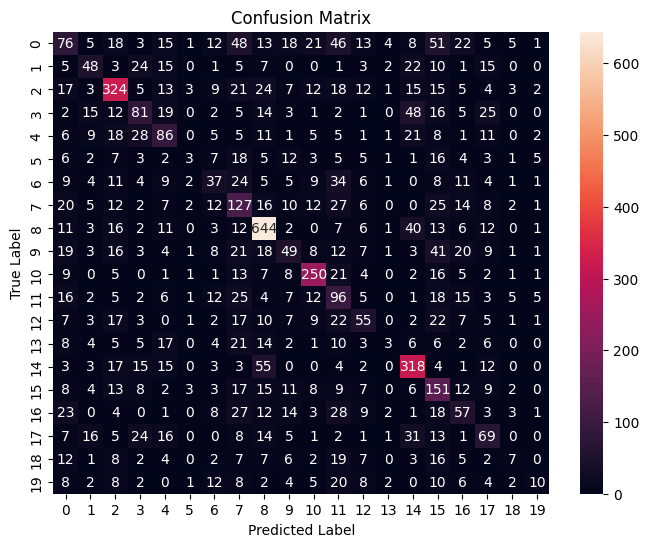

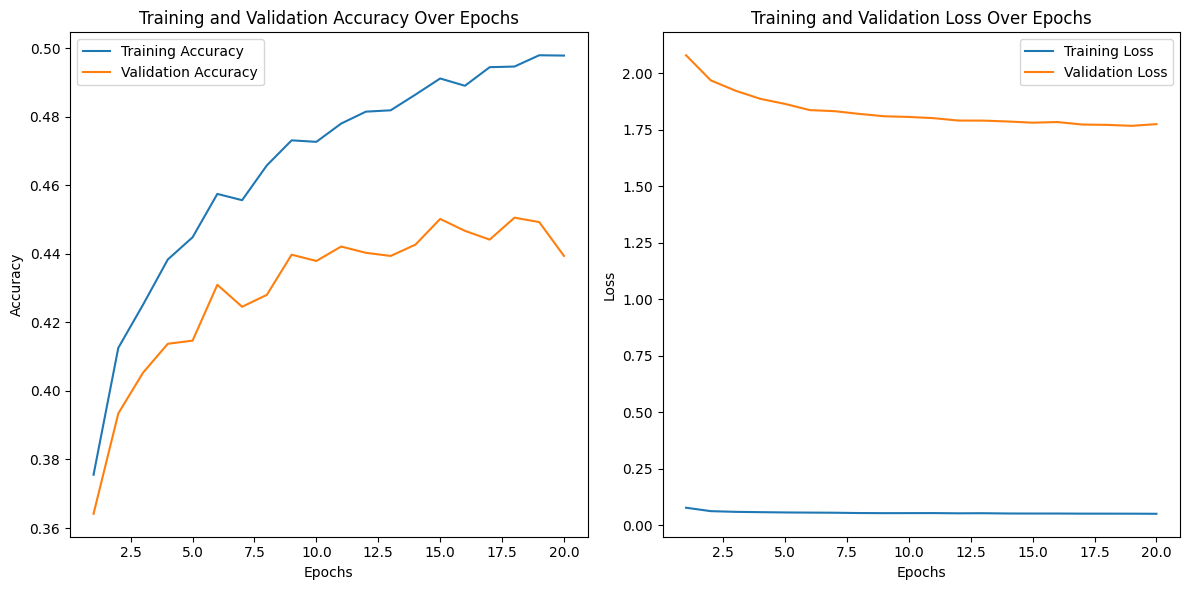

In [34]:
# Plot the confusion matrix
cm = confusion_matrix(labels_test_np, test_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Plot accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

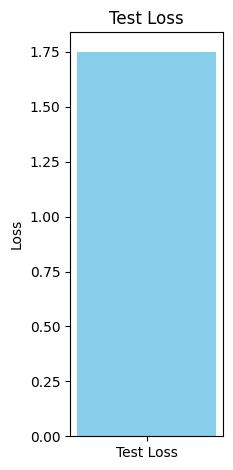

In [35]:
plt.subplot(1, 3, 3)
plt.bar(["Test Loss"], [test_loss_value], color="skyblue")
plt.title("Test Loss")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()